## Combine Climate and DropNa data

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## Load DropNa data & Change Time Formate

In [ ]:
drop_file = 'DropNa2015'
drop_df = pd.read_csv('../datas/DropNa/{}.csv'.format(drop_file))

In [ ]:
# check nan
print(drop_df.isnull().any())
# fill na as -1  Dropoff_Community_Area 有空值但需要保留 填入-1
drop_df['Dropoff_Community_Area'].fillna(value='-1', inplace=True)
# drop 其他空值
drop_df = drop_df.dropna()
# check nan 
print(drop_df.isnull().any())

In [ ]:
# replace string to float 維持經緯度資料型態一致性
drop_df.replace('nodroplat','-1.0',inplace=True)
drop_df.replace('nodroplon','-1.0',inplace=True)
drop_df['Dropoff_Centroid_Latitude']=drop_df['Dropoff_Centroid_Latitude'].astype('float64')
drop_df['Dropoff_Centroid_Longitude']=drop_df['Dropoff_Centroid_Longitude'].astype('float64')

In [ ]:
# del trip money is 0
drop_final = drop_final[drop_final['Trip_Miles']!=0]
drop_final = drop_final[drop_final['Trip_Seconds']!=0]
drop_final = drop_final[drop_final['Trip_Total']!=0]

In [ ]:
# check values types
drop_df.dtypes

In [ ]:
# 時間型態轉換
drop_df['Trip_Start_Timestamp'] = pd.to_datetime(drop_df['Trip_Start_Timestamp'],format='%m/%d/%Y %I:%M:%S %p')
drop_df['Trip_Start_Timestamp']=drop_df['Trip_Start_Timestamp'].map(lambda x:x.strftime("%Y-%m-%d %H:00:00"))
# add date、time、week columns
drop_df['Trip_Start_Timestamp'] = pd.to_datetime(drop_df['Trip_Start_Timestamp'],format='%Y-%m-%d %H:%M:%S')
drop_df['Date'] = drop_df['Trip_Start_Timestamp'].map(lambda x:x.strftime('%Y/%m/%d'))
drop_df['Time'] = drop_df['Trip_Start_Timestamp'].map(lambda x:x.strftime("%H:%M:%S"))
# Monday=0, Sunday=6
drop_df['Week']=drop_df['Trip_Start_Timestamp'].dt.dayofweek
drop_df['Week']=drop_df['Week']+1

In [ ]:
# add DATE column for merge climate data
drop_df['Trip_Start_Timestamp']=drop_df['Trip_Start_Timestamp'].map(lambda x:x.strftime("%Y-%m-%d %H:00:00"))
drop_df.insert(0, column="DATE", value=drop_df['Trip_Start_Timestamp'])

## Load climate data & Change Time Formate

In [ ]:
climate_file = 'wh_2015'
cli = pd.read_csv('../datas/climate/{}.csv'.format(climate_file))

In [ ]:
# check nan
cli.isnull().any()

In [ ]:
# check values types
cli.dtypes

In [ ]:
# 時間轉型
cli['DATE'] = pd.to_datetime(cli['DATE'],format='%Y-%m-%d %H:%M:%S')
# 氣候時間轉型--分秒設00
cli['DATE']=cli['DATE'].map(lambda x:x.strftime("%Y-%m-%d %H:00:00"))
# 刪除重複
cli.drop_duplicates(subset='DATE',keep='first', inplace=True)

## Merge DropNa data & Climate data

In [ ]:
drop_final = pd.merge(drop_df,cli,on='DATE',how='left')

In [ ]:
# delete DATE column
drop_final=drop_final.drop('DATE',axis=1)

In [ ]:
# reorder columns
drop_final=drop_final[['Trip_Start_Timestamp','Date','Time','Week','Trip_Seconds','Trip_Miles','Pickup_Community_Area',
             'Dropoff_Community_Area','Fare','Tips','Tolls','Extras','Trip_Total','Payment_Type','Company',
             'Pickup_Centroid_Latitude','Pickup_Centroid_Longitude','Dropoff_Centroid_Latitude','Dropoff_Centroid_Longitude'
             ,'Temperature','HourlyPrecipitation','HourlyVisibility','HourlyWindSpeed']]

## Load Fina data and change TimeStamp

In [22]:
file = 'Taxi2018'
df_2018 = pd.read_csv('./datas/final/{}.csv'.format(file))
df = df.drop('Time',axis=1) # 原本的Time資料沒有調整成以小時計算 所以刪除重新定義

In [ ]:
df.dtypes

In [ ]:
# 時間轉型
df['Trip_Start_Timestamp'] = pd.to_datetime(df['Trip_Start_Timestamp'],format='%Y-%m-%d %H:%M:%S')
# wash時間轉型--分秒設00
df['Trip_Start_Timestamp']=df['Trip_Start_Timestamp'].map(lambda x:x.strftime("%Y-%m-%d %H:00:00"))
df['Trip_Start_Timestamp'] = pd.to_datetime(df['Trip_Start_Timestamp'],format='%Y-%m-%d %H:%M:%S')
df['Time'] = df['Trip_Start_Timestamp'].map(lambda x:x.strftime("%H:%M:%S"))

In [ ]:
# del trip money is 0
df = df[df['Trip_Miles']!=0]
df = df[df['Trip_Seconds']!=0]
df = df[df['Trip_Total']!=0]

## conat washed_datas and dropna_datas
### check outliers and drop it

In [ ]:
final_df = pd.concat([df,drop_final])
final_df.count()

In [ ]:
final_df['mph'] = (final_df['Trip_Miles']/(final_df['Trip_Seconds']/3600))

#### 跳表規則：https://yellowcabchicago.com/rates/

In [6]:
# del fare outliers 根據跳表規則
out = final_df[(final_df['Fare'] > (((final_df['Trip_Miles']*2.25)+(final_df['Trip_Seconds']/36)*0.2)+3.25)*5)
       | (final_df['Fare']<3.25)
       | ((final_df['Trip_Miles']<1) & (final_df['Trip_Seconds']<36) & (final_df['Fare']>3.25))
       | (final_df['mph'] > 100)
       | ((final_df['mph'] < 1) & (final_df['Trip_Seconds']>1800))].index

In [ ]:
final_df.drop(out , inplace=True)

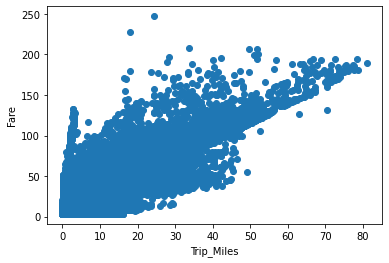

In [26]:
# vision
y= final_df[['Trip_Miles','Trip_Seconds','Trip_Total','Fare','Tips','Extras','Tolls','mph']]
x = np.array(y)
plt.scatter(x[:,0],x[:,3])
plt.xlabel('Trip_Miles')
plt.ylabel('Fare')
plt.show()

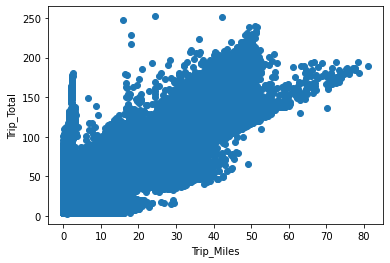

In [27]:
plt.scatter(x[:,0],x[:,2])
plt.xlabel('Trip_Miles')
plt.ylabel('Trip_Total')
plt.show()

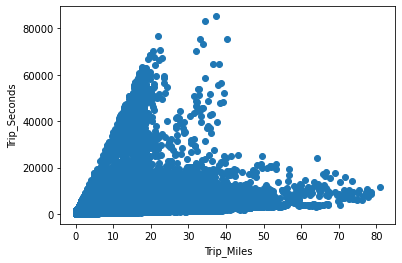

In [28]:
plt.scatter(x[:,0],x[:,1])
plt.xlabel('Trip_Miles')
plt.ylabel('Trip_Seconds')
plt.show()

In [ ]:
# IsolationForest find outliers
clf = IsolationForest( max_features=8,max_samples=1000000,n_estimators =1, 
                      random_state = 1000, contamination= 0.002)

preds = clf.fit_predict(y).tolist()
y['outliers']=preds
y = y[(y['outliers']==1)]

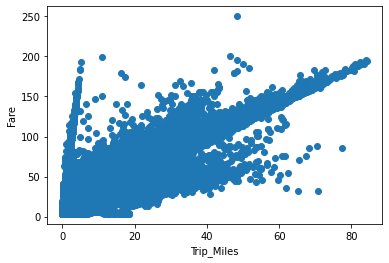

In [17]:
# vision check
x = np.array(y)
plt.scatter(x[:,0],x[:,3])
plt.xlabel('Trip_Miles')
plt.ylabel('Fare')
plt.show()

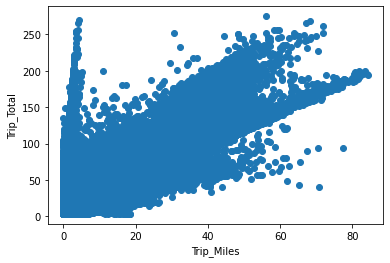

In [18]:
plt.scatter(x[:,0],x[:,2])
plt.xlabel('Trip_Miles')
plt.ylabel('Trip_Total')
plt.show()

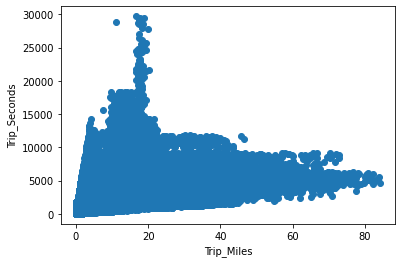

In [19]:
plt.scatter(x[:,0],x[:,1])
plt.xlabel('Trip_Miles')
plt.ylabel('Trip_Seconds')
plt.show()

In [ ]:
# del IsolationForest outliers
final_df['outliers']=preds
final_df = final_df[(final_df['outliers']==1)]
# out1 = final_df[(final_df['Trip_Miles']>90)].index
# final_df.drop(out1 , inplace=True)

In [ ]:
final_df = final_df.drop('outliers',axis=1)
# reorder columns
final_df=final_df[['Trip_Start_Timestamp','Date','Time','Week','Trip_Seconds','Trip_Miles','mph','Pickup_Community_Area',
             'Dropoff_Community_Area','Fare','Tips','Tolls','Extras','Trip_Total','Payment_Type','Company',
             'Pickup_Centroid_Latitude','Pickup_Centroid_Longitude','Dropoff_Centroid_Latitude','Dropoff_Centroid_Longitude'
             ,'Temperature','HourlyPrecipitation','HourlyVisibility','HourlyWindSpeed']]

In [ ]:
# Latitude & Longitude 整理小數到6位
final_df.dtypes
final_df['Pickup_Centroid_Latitude']=round(final_df['Pickup_Centroid_Latitude'],6)
final_df['Pickup_Centroid_Longitude']=round(final_df['Pickup_Centroid_Longitude'],6)
final_df['Dropoff_Centroid_Latitude']=round(final_df['Dropoff_Centroid_Latitude'],6)
final_df['Dropoff_Centroid_Longitude']=round(final_df['Dropoff_Centroid_Longitude'],6)

In [ ]:
# 抓上車點重複值 並傳回編號
dups = final_df.duplicated(subset=['Pickup_Centroid_Latitude','Pickup_Centroid_Longitude'], keep=False)
final_df = final_df.assign(Pickup_id=final_df['Pickup_Centroid_Latitude'].where(dups).astype('category').cat.codes)

In [ ]:
# drop pick_up id只有一筆資料的區域
final_df =final_df[final_df['Pickup_id']<0]

In [ ]:
# save csv
final_df.to_csv('../output_datas/Taxi2015.csv',index=False)